> Updates( 05/28/2018 )

> Conclusion: 
>> Age feature seems to be meanless except the minor.

>>If you wanna to try something, CV score perhaps is not reliable.

>>In this special case, I infer the age distributions of testing set respect to survival is totally different so that getting a worse score when including age feature.

>Discard All Age left Minor: 

>>Adjusted our codes to Oscar's insight and dig deeper.

>Compare Pclass + Title +Minor and Minor using RFECV:
>>Pclass + Title + Minor got a better CV score.

# Introduction
This kernel is **NOT** for beginner, but for who has been fimiliar with titanic dataset. Several strategies for missing age were introduced with many kernels.
And each author keeps his/her thinking separately which make me confused about it."Which one method works better?" came into my mind hundreds of times. If it bothers you too, you are the audience.

This kernel gonna to compare 3 different strategies via RFECV with RandomForest feature importance based and LB-score:

(1) Using Title Median.

(2) Using Title + Pclass Median.

(3) Discard All Age + Minor.

 

In [49]:
# loading package
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from IPython.display import display
# loading data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_data = df_train.append(df_test)

# Missing Age
We know that nearly 20% missing in age and it matters for our prediction.
You could see a lot of kaggler filling with the median for simple. Or with title feature extracted from Name seems more confident. Some people fill it with regression using other features. The features may be correlate with age, but if there is no sense about why. I truly debted because there is no specific reason and probably just noise in it. [An analysis](https://www.kaggle.com/pliptor/divide-and-conquer-0-82296) shows that the missing age distributed Pclass = 3 mainly by Oscar. He recommends that discard **all age** to prevent our model from noise. We will compare that thought finally.

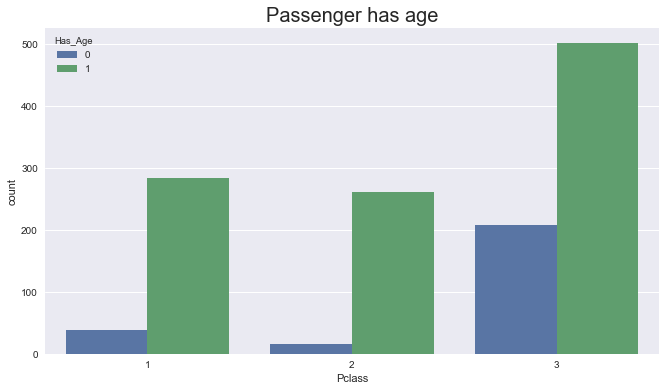

In [50]:
df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig = plt.figure(figsize=(11,6))
ax = sns.countplot(df_data['Pclass'],hue=df_data['Has_Age'])
ax.set_title('Passenger has age',fontsize = 20)

# Combining Pclass & Age
Let's dig deeper into the way filling with Title. You can try box plot with age respect to other feature like Sex, Pclass, Parch, SibSp, Fare, and so on.
I noticed that combing the Pclass feature and title feature seems more accurate. The reason is that a lager age (during  20~50) statistically indicate their social standing. Depends on social standing :
  * The child should be excluded. We can see the same median in Title = Master
  * Title = Mr, Mrs, Miss are included. We can see the effort by eye.
  * Title = Rare introduces noise. Fountunely, there is only 1 missing age is relative to Title = Rare
  
  
You might ask why we need to experiment? Is it obvious correct?
Although it seems correct, we probably introduce more noise at the same time. So there are two effects against.

**Reasonable Pclass + Title** and **Noise Introduced meanwhile**  

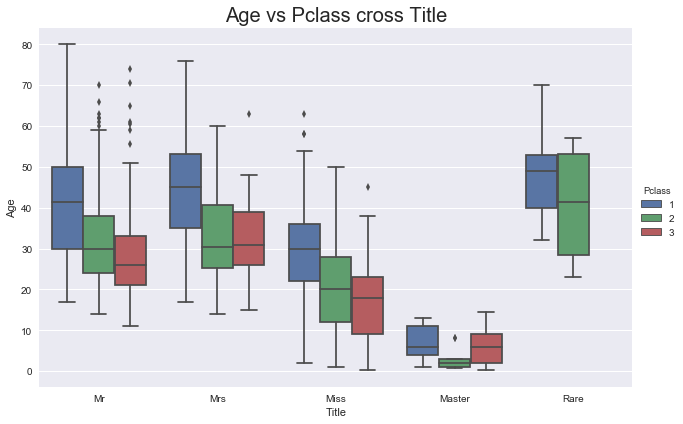

In [51]:
# extracted title using name
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'],'Mrs')
g = sns.factorplot(y='Age',x='Title',kind='box',hue='Pclass', data=df_data, 
               size=6,aspect=1.5)
plt.subplots_adjust(top=0.93)
g.fig.suptitle('Age vs Pclass cross Title', fontsize = 20)

In [52]:
missing_mask = (df_data['Has_Age'] == 0)
pd.crosstab(df_data[missing_mask]['Pclass'],df_data[missing_mask]['Title'])

Title,Master,Miss,Mr,Mrs,Rare
Pclass,,,,,
1,0,1,27,10,1
2,0,2,13,1,0
3,8,48,136,16,0


In [53]:
# filling Missing age with Pclass & Title
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2, "Miss" : 3, "Mrs" : 4 })
Pclass_title_pred = df_data.pivot_table(values='Age', index=['Pclass'], columns=['Title'],aggfunc=np.median).values
df_data['P_Ti_Age'] = df_data['Age']
for i in range(0,5):
    # 0,1,2,3,4
    for j in range(1,4):
        # 1,2,3
            df_data.loc[(df_data.Age.isnull()) & (df_data.Pclass == j) & (df_data.Title == i),'P_Ti_Age'] = Pclass_title_pred[j-1, i]
df_data['P_Ti_Age'] = df_data['P_Ti_Age'].astype('int')

# filling Missing age with Title only

Ti_pred = df_data.groupby('Title')['Age'].median().values
df_data['Ti_Age'] = df_data['Age']
for i in range(0,5):
 # 0 1 2 3 4
    df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i),'Ti_Age'] = Ti_pred[i]
df_data['Ti_Age'] = df_data['Ti_Age'].astype('int')



# Cutting into Bins
There are several ways to cut age to bins :
 * Since age distributed [0,80], some EDA kernels cut bin with age region divide 4 or 5 bins in order to show a pretty figure. But this cutting will face a skew class problem when training a model. I suggest that don't use such kinds of cutting.
 * The quantile-based discretization prevents our model from the skew problem above. As for how many bins or a specific quantile cutting work better? I have no significant idea either. If you know about this issue, please let me know. I will be appreciated. Here we just cut into 4 quartile using qcut in pandas.

In [54]:
df_data['P_Ti_AgeBin'] = pd.qcut(df_data['P_Ti_Age'], 4)
df_data['Ti_AgeBin'] = pd.qcut(df_data['Ti_Age'], 4)
label = LabelEncoder()
df_data['P_Ti_Code'] = label.fit_transform(df_data['P_Ti_AgeBin'])
df_data['Ti_Code'] = label.fit_transform(df_data['Ti_AgeBin'])

In [1]:
# convet sex on to 0 1
df_data['Sex'] = df_data['Sex'].map( {'female' : 1, 'male' : 0}).astype('int')
# separate feature form whole dataset
df_train[['Sex','P_Ti_Code','Ti_Code']] = df_data[['Sex','P_Ti_Code','Ti_Code']][:len(df_train)]
df_test[['Sex','P_Ti_Code','Ti_Code']] = df_data[['Sex','P_Ti_Code','Ti_Code']][len(df_train):]

NameError: name 'df_data' is not defined

# Other Testing Feature
Here we use just 3 features (Sex, Pclass, Age) for simple.
Talking about feature scaling, since we use RF which work by separated data using impurity function (gini and entropy) here. So we don't need it. 

In [56]:
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']
P_Ti_vs_Ti = ['Sex', 'Pclass', 'P_Ti_Code', 'Ti_Code']
X[P_Ti_vs_Ti].head()

,Sex,Pclass,P_Ti_Code,Ti_Code
0,0,3,1,0
1,1,1,3,3
2,1,3,1,1
3,1,1,2,2
4,0,3,2,2


#  Compare Pclass + Title and Tilte Only using RFECV

RFECV is a method that adding feature one by one and test with cv.
You can check the doc [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

The benefit:

 * Concluding the feature interaction with the target.
i.e. male with AgeBin_Code = 1 in Pclass = 1 will survive more than Pclass = 2. It is what chi-square or others single feature testing cannot achieve.

The shortcomings:

 * Obviously, it will take a long time to select feature which is bad if the dataset is large.
 * Depends on cv score but such kind of small dataset, it still overfits if we tune the hyperparameters too much. So I set min_sample_splits = 20 to prevent it happened.

## Cross-Validation and Bias 
Many books and kernels told you cross-validation could prevent the model from overfitting. I think it is 95% right. but not for Titanic dataset. My experience on Titanic dataset is that I tuned parameters using cross-validation on training set and get above 0.82~0.89 on both cross validation score in training set and hold out validation set. But I often got a bad score on LB public. Then, I observe my parameter and tuned it into smaller score. the holdout score decreases too and I get a higher LB public. That's just the scene in cross-validation with in-sample accuracy and validation accuracy but now with holdout validation set and LB public.
This problem bothers me several weeks, I think the reason :

* A data set be separated two sets: train and test. Then their
survival distribution with age is different. we train our model with age feature, and yes it works well respect to training set age distribution.
But the distribution of testing set might different. Then LB score gets down.
It's called bias which is different with the concept 'overfitting'.
In this case, you'll see cv score grows up and LB score get down.


So, be careful when adding features to test the model performance.
Cross-Validation can't help you distinguish it. 



In [9]:
selector = RFECV(RandomForestClassifier(n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
selector.fit(X[P_Ti_vs_Ti], Y)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100)

NameError: name 'X' is not defined

## Different CV Random State and Model Random State
Consider a small data set, the result probably just noise due to cv arrangement. I suffered that testing some features and its result varied with random state. 

 
  Let's test over more random_state to make sure our result is true.

In [37]:
seeds = 10
P_Ti_vs_Ti_diff = np.zeros(seeds)
for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
    selector = RFECV(RandomForestClassifier(random_state=i,n_estimators=250,min_samples_split=20),cv=diff_cv,n_jobs=-1)
    selector.fit(X[P_Ti_vs_Ti], Y)
    P_Ti_vs_Ti_diff[i] = ( selector.grid_scores_[2] - selector.grid_scores_[3] )*100


In [38]:
fig = plt.figure(figsize=(18,8))
ax  = plt.gca()
difference_plot = ax.bar(range(seeds),P_Ti_vs_Ti_diff,color='g')
plt.xlabel(" Seed # ",fontsize = "14")
ax.set_title("P_Ti vs Ti",fontsize=20)
plt.ylabel("score difference  % ", fontsize="14")
mean = P_Ti_vs_Ti_diff.mean()
ax.axhline(mean)

I tried many times and get 0.1~0.6 improve in cv score if don't set any random state. Now it's all fixed, you should get the same result when you fork.

**Now we have more confidence to say that "Strategy using Pclass + Title" performs better than "Strategy using Title Only"**

# Discard All Age left Minor
As we discussed earlier, Oscar thinks that Filling 20% missing age will introduce more noise included and age feature doesn't play a primary role in most algorithms Furthermore, he builds a feature "Minor" which are Child(Age < 14.0) in Pclass = 1 and Pclass = 2 which survived more. 
Okay, Let's dig deeper, too. It's reasonable to infer that children survived more no matter Pclass = 1,2 or 3 hypothetically. The result shows below using training set only and it is worthy to test.
As for our strategy which filling with Pclass and Title, to align that thought, There are two effects against :

**Pclass + Title Filling Missing Age and Noise Introduced meanwhile + Minor **

vs 

**Minor in Pclass = 1 and 2 and 3 + Discard Other Age + Bias  ** 

In [57]:
Minor_mask = (df_train.Age <= 14) 
Not_Minor_mask = (df_train.Age > 14) 
display(df_train[Minor_mask][['Pclass','Survived']].groupby(['Pclass']).mean())
display(df_train[Not_Minor_mask][['Pclass','Survived']].groupby(['Pclass']).mean())

,Survived
Pclass,
1,0.800000
2,1.000000
3,0.415094


,Survived
Pclass,
1,0.651934
2,0.415584
3,0.208609


Due to filling the missing age, we got more 8 Mater include. Let's call the feature **P_Ti_Minor**.

In [58]:
df_data['Age_copy'] = df_data['Age'].fillna(-1)
df_data['Minor'] = (df_data['Age_copy'] < 14.0) & (df_data['Age_copy']>= 0)
df_data['Minor'] = df_data['Minor'] * 1
# We could capture more 8 Master in Pclass = 3 by filling missing age 
df_data['P_Ti_Minor'] = ((df_data['P_Ti_Age']) < 14.0) * 1
(df_data['P_Ti_Minor'] - df_data['Minor']).sum()

8

In [59]:
# separate feature form whole dataset
df_train[['P_Ti_Minor', 'Minor']] = df_data[['P_Ti_Minor', 'Minor']][:len(df_train)]
df_test[['P_Ti_Minor' , 'Minor']] = df_data[['P_Ti_Minor', 'Minor']][len(df_train):]

In [60]:
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']
P_Ti = ['Sex', 'Pclass', 'P_Ti_Code', 'P_Ti_Minor']
Discard = ['Sex','Pclass','Minor']
display(X[P_Ti].head())
display(X[Discard].head())

,Sex,Pclass,P_Ti_Code,P_Ti_Minor
0,0,3,1,0
1,1,1,3,0
2,1,3,1,0
3,1,1,2,0
4,0,3,2,0


,Sex,Pclass,Minor
0,0,3,0
1,1,1,0
2,1,3,0
3,1,1,0
4,0,3,0


#  Compare Pclass + Title + Minor and  Minor using RFECV


This time, we cannot just put all into model together. Because  we want to test the effect composed of two features, not one.

So we run two times RFECV and see the results. Yes, Actually just compare the cv score.

In [29]:
selector_P_Ti = RFECV(RandomForestClassifier(n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
selector_P_Ti.fit(X[P_Ti], Y)
selector_Discard = RFECV(RandomForestClassifier(n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
selector_Discard.fit(X[Discard], Y)
print(selector_P_Ti.support_)
print(selector_P_Ti.ranking_)
print(selector_P_Ti.grid_scores_*100)
print(selector_Discard.support_)
print(selector_Discard.ranking_)
print(selector_Discard.grid_scores_*100)

## Different CV Random State and Model Random State

In [34]:
seeds = 10
P_Ti_vs_Discard = np.zeros(seeds)
for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
    selector_P_Ti = RFECV(RandomForestClassifier(random_state=i,n_estimators=250,min_samples_split=20),cv=diff_cv,n_jobs=-1)
    selector_P_Ti.fit(X[P_Ti], Y)
    selector__Discard = RFECV(RandomForestClassifier(random_state=i,n_estimators=250,min_samples_split=20),cv=diff_cv,n_jobs=-1)
    selector__Discard.fit(X[Discard], Y)
    # print(selector_P_Ti.grid_scores_[3],selector__Discard.grid_scores_[3])
    P_Ti_vs_Discard[i] = ( selector_P_Ti.grid_scores_[3] - selector__Discard.grid_scores_[2] )*100
    # print(P_Ti_vs_Discard)


In [35]:
fig = plt.figure(figsize=(18,8))
ax  = plt.gca()
difference_plot = ax.bar(range(seeds),P_Ti_vs_Discard,color='g')
plt.xlabel(" Seed # ",fontsize = "14")
ax.set_title("P_Ti vs Discard",fontsize=20)
plt.ylabel("score difference  % ", fontsize="14")
mean = P_Ti_vs_Discard.mean()
ax.axhline(mean)

Once we fix the random state, it easily show the result without the CV Variance and Model Variance. The result seems to show that Pclass + Title perform better

# LB Score
I think a workflow like that is a standard procedure for feature selection ** if the distribution of training set and testing set are the same.**
But when we submit our result, everything change. It goes better that **DISCARD WIN**. That's what I'm talking about the bias problem. I'm pretty sure that I'm NOT the first person faced the problem.

## Base Model 
In order to compare the three strategies on LB, we need to set a baseline model which mentioned here, You should get a points 0.76555 with Sex and Pclass only.

In [34]:
Base = ['Sex','Pclass']
Base_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_),'   LB_Public : 0.76555')

Base oob score :0.73176    LB_Public : 0.76555


In [35]:
Ti = ['Sex', 'Pclass', 'Ti_Code']
P_Ti_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
# Note that even we change the split = 40 , 50 , 70 seems to underfit, the same LB_Public they did.
P_Ti_Model.fit(X[P_Ti], Y)
Discard_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
# spilit = 20 , 40 LB = 0.77511
Discard_Model.fit(X[Discard], Y)
Ti_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=10,oob_score=True)
# split = 10, 20, 40 --> LB = 0.741, spilits = 50 , underfit , LB = 0.732
Ti_Model.fit(X[Ti], Y)
Ti_Model.oob_score_
print('P_Ti oob score :%.4f' %(P_Ti_Model.oob_score_),'   LB_Public : 0.74162')
print('Discard oob score :%.4f '%(Discard_Model.oob_score_),' LB_Public : 0.77511')
print('Ti oob score : %.4f' %(Ti_Model.oob_score_), '  LB_Public : 0.74162')

P_Ti oob score :0.8002    LB_Public : 0.74162
Discard oob score :0.7396   LB_Public : 0.77511
Ti oob score : 0.7901   LB_Public : 0.74162


# Conclusion

We have done an experiment and show that the critical perspective :
* **Age feature maybe not a good feature to use, but we could extract Minor from it which might help.**



* **CV result seems to be unreliable if we encounter a bias problem.** If you have any idea about improve the score, you should test it on LB to see what happened.

* Considering RFECV and LB score, the performance :
**Discard All Age + Minor > Pclass + Title Filling Missing Age ~ Title Only Filling Missing Age**




If there is something wrong with my analysis, please let me know and improve it. I'm happy to hear some comment about feature selection issue and the whole machine learning concept. It's my opportunity to get improve my skills. Finally, **if you like this kernel, please upvote and send a comment to let me know.** Thanks for your reading.

# Additional

In [38]:
Discard_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
# spilit = 20 , 40 LB = 0.77511
Discard_Model.fit(X[Discard], Y)
print('Discard oob score :%.4f '%(Discard_Model.oob_score_),' LB_Public : 0.77511')

Discard oob score :0.7396   LB_Public : 0.77511


In [41]:
X[P_Ti].head()

,Sex,Pclass,P_Ti_Code,P_Ti_Minor
0,0,3,1,0
1,1,1,3,0
2,1,3,1,0
3,1,1,2,0
4,0,3,2,0


In [70]:
# drop P_Ti_Code after filling 8 Masters
P_Ti = ['Sex', 'Pclass', 'P_Ti_Minor']
P_Ti_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=30,oob_score=True)
# split = 25 0.7897 oob , 30 0.7486 oob
P_Ti_Model.fit(X[P_Ti], Y)
print('P_Ti oob score :%.4f' %(P_Ti_Model.oob_score_),'   LB_Public : 0.7751')

P_Ti oob score :0.7486    LB_Public : X


In [71]:
'''X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

P_Ti_pred = P_Ti_Model.predict(X_Submit[P_Ti])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":P_Ti_pred})
submit.to_csv("submit/submit_50.csv",index=False)''';